* Author: HZQ
* Last modified: 2018/12/17

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p driver
!google-drive-ocamlfuse driver
import os
os.chdir("driver/Colab Notebooks/CategoryRecom_kaggle/")
!ls

In [0]:
!ls

In [0]:
!pip install tushare
!pip install statsmodels

In [0]:
!pip install --upgrade pandas

# Main Parts

### Import required packages

In [0]:
import pprint, sys, copy
import functools

import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import tushare as ts  # for convenient fetch of stock data
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA  # import financial sequence model ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  # grab params for financial sequence model

### read data offline

In [0]:
DATA_ROOT_PATH = "./data/"

In [0]:
data_train_path = DATA_ROOT_PATH + "data_raw/train/train.csv"
data_test_path = DATA_ROOT_PATH + "data_raw/test/test.csv"
data_valid_path = DATA_ROOT_PATH + "data_raw/valid/valid.csv"
data_info_path = DATA_ROOT_PATH  + "data_raw/Data_Dictionary.xlsx"
data_merchants_path = DATA_ROOT_PATH + "data_raw/merchants.csv"
data_his_trans_path = DATA_ROOT_PATH + "data_raw/historical_transactions.csv"
data_new_trans_path = DATA_ROOT_PATH + "data_raw/new_merchant_transactions.csv"

data_train = pd.read_csv(data_train_path)
data_test = pd.read_csv(data_test_path)
data_valid = None
data_info = pd.read_excel(data_info_path)
data_merchants = pd.read_csv(data_merchants_path)
# data_historical_transactions = pd.read_csv(data_his_trans_path)  # Note 2018/12/13: Not imported yet for decreasing the cpu usage
data_new_merchant_transactions = pd.read_csv(data_new_trans_path)

### read data online

### check data properties

In [0]:
def check_basically(data_path, data):
    type_dict = {}
    name_file = data_path.split('/')[-1]
    name_var = 'data_' + name_file[:-4]
    print("[Input] File Name: {}, basic checking for variable {} fetched from it".format(name_file, name_var))
    print("[Output] The file data type of each column: ")
    print("[Note]: Assumption: all data in one column share the same data type")
    for indent in range(data.shape[1]):
        type_dict[data.columns[indent]] = str(type(data.iloc[0, indent]))  # Note 2018/12/14: use str() to avoid "ValueError: invalid __array_struct__"
    type_df = pd.DataFrame(data=type_dict, index=[0])
    pprint.pprint(type_df)
    print("\n")
    print("[Output] The shape of file data: ")
    pprint.pprint(data.shape)
    print("\n")
    print("---End Line---")
    print("\n")
    

check_basically(data_train_path, data_train)
check_basically(data_test_path, data_test)

#### check completion

In [0]:
def check_completion(data_path, data):
    name_file = data_path.split('/')[-1]
    name_var = 'data_' + name_file[:-4]
    print("[Input] File Name: {}, completion checking for variable {} fetched from it".format(name_file, name_var))
    print("[Output] The fifth rows of raw data: ")
    pprint.pprint(data.head())
    print("\n")
    print("[Output] The useful statisitical indexes of whole data: ")
    pprint.pprint(data.describe())
    print("\n")
    print("[Output] The vacancy numbers of whole data: ")
    pprint.pprint(data.isnull().sum())
    print("\n")
    print("---End Line---")
    print("\n")
    
check_completion(data_train_path, data_train)
check_completion(data_test_path, data_test)
# check_completion(data_merchants_path, data_merchants)
# check_completion(data_his_trans_path, data_his_trans)
# check_completion(data_new_trans_path, data_new_trans)

#### survivor bias

In [0]:
# @functools.lru_cache(maxsize=128)  # Note 2018/12/14: commented to avoid "TypeError: 'DataFrame' objects are mutable"
def check_survivor_bias(data_path, data, label):
    name_file = data_path.split('/')[-1]
    name_var = 'data_' + name_file[:-4]    
    print("[Input] File Name: {}, survivor bias checking for variable {} fetched from it".format(name_file, name_var))
    print("[Output] The distribution of vacancy: ")
    
    target_set = list(set(data[label]))
    biascollector_survivor_dict = {each_target: len(data[label][data[label] == each_target]) for each_target in target_set}
    biascollector_survivor_df = pd.DataFrame(data=biascollector_survivor_dict, index=[0])
    biascollector_survivor_df.to_csv("./model/collector/bias_survivor_collector.csv", index=False)
    pprint.pprint(biascollector_survivor_df)    
    plt.plot(target_set, list(biascollector_survivor_dict.values()), 'ro', linewidth=2)
    # sns.countplot(x='target', data=data_train);
    print("\n")
    print("---End Line---")
    print("\n")

    
check_survivor_bias(data_train_path, data_train, 'target')
# check_survivor_bias(data_test_path, data_test, '')

#### check time-related

In [0]:
import gc
gc.collect()
sys._clear_type_cache()

In [0]:
data_train.rolling?

In [0]:
pd.to_datetime(data_train['first_active_month'])

In [0]:
data_train_copy = copy.copy(data_train)
data_train_copy.set_index(pd.to_datetime(data_train_copy['first_active_month']), inplace=True)
data_train_copy = data_train_copy.sort_index()
pprint.pprint(data_train_copy.head(10))
fig2 = plt.figure(figsize=(10, 12));
ax1 = fig2.add_subplot(311) 
plt.plot_date(x=data_train_copy.index, y=data_train_copy['target'], xdate=True, marker=None, linestyle='solid', color='darkblue', label='target');
plt.legend(loc='upper left')
ax2 = fig2.add_subplot(312) 
data_train_copy['target'].rolling(6).mean().plot(color='darkgreen', label='target_rolling_mean');
plt.legend(loc='upper left')
ax3 = fig2.add_subplot(313) 
data_train_copy['target'].rolling(6).std().plot(color='yellow', label='target_rolling_std');
plt.legend(loc='upper left')
# data_train_copy_resampled = data_train_copy.resample('W-MON')  # 数据太多时的降频处理, TODO 2018/12/17: ModuleNotFoundError: No module named 'pandas.core.groupby.groupby'; 'pandas.core.groupby' is not a package
# data_train_copy_resampled.plot(color='darkred')

In [0]:
LABELS = ['adf statistics', 'p value', 'used lag', 'NUmber of oberservation']


# @functools.lru_cache(maxsize=128)
def check_adfuller(data):
    results = adfuller(x=data, maxlag=12)
    for label, result in zip(LABELS, results):
        print(label + ': ' + str(result))
    if results[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, accept the null hypothesis")
        print("Data has unit root and is non-stationary")    

In [0]:
check_adfuller(data_train_copy['target'])

In [0]:
fig2 = plt.figure(figsize=(10, 12));
ax1 = fig2.add_subplot(211) 
print("[Input] Data: {}, visualization for variable {} with data stored in".format('first derivative of \'target\'', 'data_train_copy[\'diff1\']'))
data_train_copy['diff1'] = data_train_copy['target'].diff(1)  # Note 2018/12/13: if needed, use '.dropna()''
# pprint.pprint(data_train_copy['diff1'])
print("[Output] visualization of vacancy numbers")
pprint.pprint(data_train_copy['diff1'].isnull())
print("\n")
print("[Output] visualization of curve trend")
data_train_copy['diff1'].plot(color='darkred', label='target_diff1', ax=ax1)
plt.legend(loc='upper left')
# print("\n")
# print("[Output] visualization of adfuller checking result")
# check_adfuller(data_train_copy['diff1'])  # TODO 2018/12/17: LinAlgError: SVD did not converge 
print("\n")
print("---End Line---")
print("\n")

ax2 = fig2.add_subplot(212) 
print("[Input] Data Part: {}, visualization for variable {} with data stored in".format('second derivative of \'target\'', 'data_train_copy[\'diff2\']'))
data_train_copy['diff2'] = data_train_copy['diff1'].diff(1)
# pprint.pprint(data_train_copy['diff2'])
print("[Output] visualization of vacancy numbers")
pprint.pprint(data_train_copy['diff2'].isnull())
print("\n")
print("[Output] visualization of curve trend")
data_train_copy['diff2'].plot(color='darkblue', label='target_diff2', ax=ax2)
plt.legend(loc='upper left')
# print("\n")
# print("[Output] visualization of adfuller checking result")
# check_adfuller(data_train_copy['diff2'])  # TODO 2018/12/17: LinAlgError: SVD did not converge 
print("\n")
print("---End Line---")
print("\n")

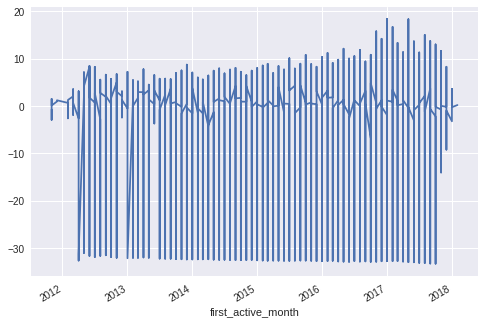

In [81]:
result_arima.resid.plot();

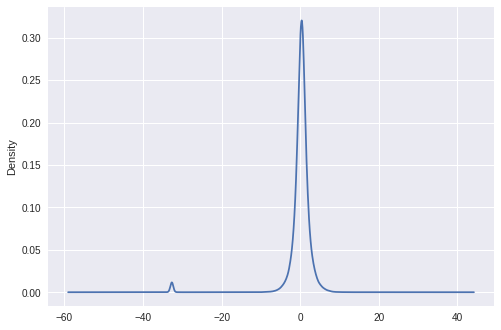

In [82]:
result_arima.resid.plot(kind='kde');

In [0]:
# References: 
# jianshu.com/p/4130bac8ebe
# jianshu.com/p/9066b9e0c7af

print("[Input] Variable: {}, determine parameters \'p, d, q\' for financial sequence model fetched from it".format('data_train_copy[\'diff1\']'))
print("[Output] visualization of acf curve")
acf = plot_acf(data_train_copy['diff1'], lags=20)
print("\n")
print("[Output] visualization of pacf curve")
pacf = plot_pacf(data_train_copy['diff1'], lags=20)
model_arima = ARIMA(data_train_copy['target'], order=(1, 1, 1), freq='W-MON')
result_arima = model_arima.fit()
print("\n")
print("---End Line---")
print("\n")

print("[Input] Variable: {}, visualization of fitting results for financial sequence model \'ARIMA\'".format('result_arima'))
print("[Output] visualization of summary")
print(result_arima.summary())
print("\n")
print("[Output] visualization of residual trend and distribution")
result_arima.resid.dropna(axis=0, inplace=True)
result_arima.resid.plot()
result_arima.resid.plot(kind='kde')
print("\n")
print("---End Line---")
print("\n")

In [0]:
result_arima.predict?

In [84]:
print("[Input] Variable: {}, visualization of prediction results for financial sequence model \'ARIMA\'".format('result_arima'))
data_train_copy['target_pred'] = result_arima.predict(start=0, end=len(data_train_copy))
print("[Output] visualization of prediction curve compared with original curve")
data_train_copy[['target', 'target_pred']].plot()
# pd.data_range(start='2018-12-1', end='2019-12-1', periods=12, freq='MS')
print("\n")
print("---End Line---")
print("\n")

[Input] Variable: result_arima, visualization of prediction results for financial sequence model 'ARIMA'


ValueError: ignored

# Test Parts

In [0]:
data_stock = ts.get_hist_data('600519')
data_stock.isna().sum()
# data_stock.index

In [0]:
print(data_stock.columns, type(data_stock))

In [0]:
mean_dict, std_dict = {'feat_low_vacancy':[], 'feat_high_vacancy':[]}, {'feat_low_vacancy':[], 'feat_high_vacancy':[]}
sns.set(style="darkgrid")
def compare_dis(data_low_vacancy, data_high_vacancy, feat_low_vacancy_si, feat_high_vacancy_si, ind):
    fig = plt.figure(num=ind, figsize=(10, 15))
    ax1 = fig.add_subplot(211)
    ax1.set_title("feat %s from low vacancy data" %feat_low_vacancy_si)
    mean_dict['feat_low_vacancy'].append(data_low_vacancy[feat_low_vacancy_si].dropna().mean())
    std_dict['feat_low_vacancy'].append(data_low_vacancy[feat_low_vacancy_si].dropna().std())
    sns.countplot(x=feat_low_vacancy_si, data=data_low_vacancy, ax=ax1);
    
    ax2 = fig.add_subplot(212)
    ax2.set_title("feat %s from high vacancy data" %feat_high_vacancy_si)
    mean_dict['feat_high_vacancy'].append(data_high_vacancy[feat_high_vacancy_si].dropna().mean())
    std_dict['feat_high_vacancy'].append(data_high_vacancy[feat_high_vacancy_si].dropna().std())
    sns.countplot(x=feat_high_vacancy_si, data=data_high_vacancy, ax=ax2);
    # sns.catplot(x="class", hue="who", col="survived", data=titanic, kind="count", height=4, aspect=.7);
    
num = 5
feats_low_selected = random.sample(list(azdias_low.columns), num)
feats_high_selected = random.sample(list(azdias_high.columns), num)
for indent in range(num):
    compare_dis(azdias_low, azdias_high, feats_low_selected[indent], feats_high_selected[indent], indent)
mean_df = pd.DataFrame(mean_dict)
std_df = pd.DataFrame(std_dict)